In [1]:
import pandas as pd
import numpy as np
import mpu
import pyproj
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.ensemble import RandomForestRegressor

geodesic = pyproj.Geod(ellps='WGS84')

pd.set_option('display.max_columns', None)



Bad key text.latex.preview in file C:\Users\saox\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\saox\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\saox\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably

In [2]:

def homoscedasticity(model, test_df, variables, y_test):
    # Fit the linear regression model and obtain residuals
    y_pred = model.predict(test_df[variables])
    residuals = y_test - y_pred

    # Plot the residuals against the predicted values
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_pred, residuals)
    ax.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0

    # Set labels and title
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title('Residuals vs Predicted Values')

    # Show the plot
    plt.show()

def pred_vs_true(model, X_test, y_test):
    preds = model.predict(X_test)
    true_values = y_test
    print(np.corrcoef(preds,true_values)[0, 1])

    plt.scatter(preds,true_values)
    plt.plot([min(preds), max(preds)], [min(true_values), max(true_values)], color='red', linestyle='--', label='y = x')
    plt.title("Predictions(x) vs true values (y)")
    plt.xlabel("Predictions")
    plt.ylabel("True values")
    return plt.show()

def test_normality(model, test_df, variables, y_test):
    y_pred = model.predict(test_df[variables])
    residuals = y_test - y_pred

    # Perform Shapiro-Wilk test for normality
    statistic, p_value = stats.shapiro(residuals)

    # Set the significance level
    alpha = 0.05

    # Check the null hypothesis
    if p_value > alpha:
        print("Residuals are normally distributed (fail to reject H0)")
    else:
        print("Residuals are not normally distributed (reject H0)")

        

def corr_matrix(df):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create the correlation matrix heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

    # Set the title
    ax.set_title('Correlation Matrix')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()
    
    
def calculate_mape(y_test, preds):
    #y_test = np.array(y_test)
    # preds = np.array(preds)
    
    non_zero_indices = y_test != 0
    y_test = y_test[non_zero_indices]
    preds = preds[non_zero_indices]
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
    
    return mape    

In [3]:
df = pd.read_csv('dataset_final.csv').drop('Unnamed: 0',axis=1)

# The dataset

In [4]:
df.head()

,sqm_price,building_floors_num,rooms_num,lat,long,build_year,price,sqm,floor_no,word_parking,word_balcony,word_basement,building_type,word_elevator
0,13343.109,6,3,52.259,20.979,2014,910000.000,68.200,5,1,1,1,block,0
1,8499.025,10,2,52.223,20.900,1982,436000.000,51.300,0,0,0,0,block,0
2,9412.217,4,2,52.309,20.982,2009,490000.000,52.060,4,1,1,0,block,0
3,15679.245,6,2,52.262,20.968,2013,831000.000,53.000,2,1,0,0,block,0
4,11708.333,7,3,52.198,21.045,2007,843000.000,72.000,5,1,1,1,apartment,1


## Warsaw

![alt text](./imgs/ds_waw_1.png "Warsaw")

<AxesSubplot:xlabel='long', ylabel='lat'>

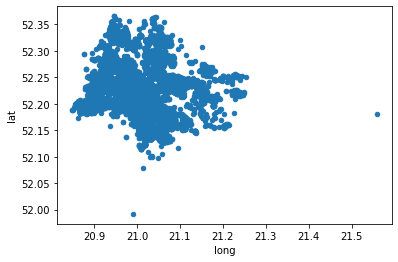

In [5]:
df.plot.scatter(x='long',y='lat')

## Inspect columns 

### Number of floors in the building

In [6]:
df = df[(df.long < 21.3) & (df.lat > 52.05)]

<AxesSubplot:xlabel='long', ylabel='lat'>

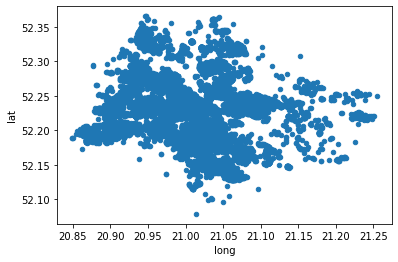

In [7]:
df.plot.scatter(x='long',y='lat')

<AxesSubplot:ylabel='Frequency'>

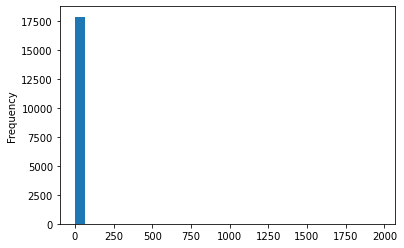

In [8]:
df.building_floors_num.plot.hist(bins=30)

In [9]:
df.building_floors_num.max()

1968

In [10]:
df.building_floors_num.value_counts()

4       3810
3       2450
5       2022
10      1961
6       1771
7       1503
2       1094
8        956
9        426
12       415
11       394
15       321
1        179
13       141
14       116
16       111
22        52
17        51
20        26
30        23
25        20
19        16
18        12
23         9
24         7
26         5
28         5
21         2
33         1
55         1
1968       1
Name: building_floors_num, dtype: int64

In [11]:
df = df[df.building_floors_num <=25]

<AxesSubplot:ylabel='Frequency'>

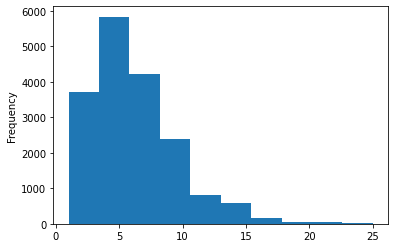

In [12]:
df.building_floors_num.plot.hist()

### Number of rooms

<AxesSubplot:>

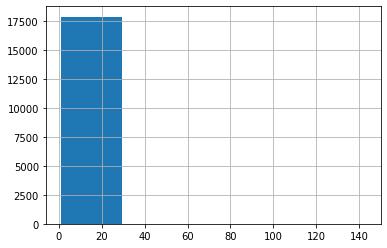

In [13]:
df.rooms_num.hist(bins=5)

In [14]:
df.rooms_num.value_counts()

3      6700
2      6460
4      2522
1      1256
5       698
6       179
7        36
8         5
9         3
10        2
13        1
143       1
15        1
62        1
Name: rooms_num, dtype: int64

In [15]:
df = df[df.rooms_num <= 10]

<AxesSubplot:>

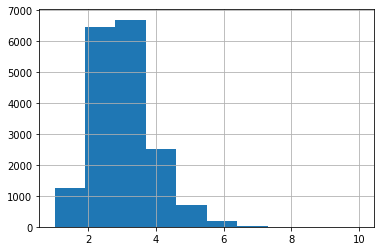

In [16]:
df.rooms_num.hist()

### History/context - Year the building was built

![alt text](./imgs/warsaw_1945.jpg "Warsaw")
After the 2nd World War - 80 to 90% of the buildings were destroyed.

<AxesSubplot:>

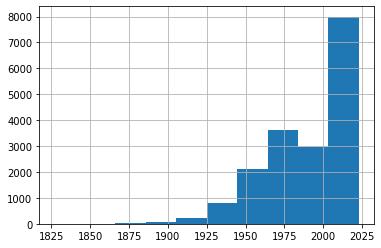

In [17]:
df.build_year.hist()

In [18]:
df['building_age'] = 2023 - df['build_year']

In [19]:
2023-1945

78

<AxesSubplot:>

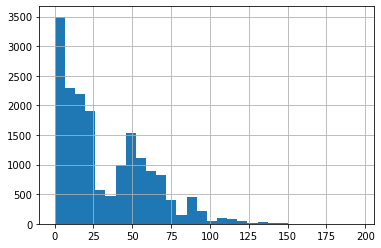

In [20]:
df['building_age'].hist(bins = 30)

### Square meters

<AxesSubplot:>

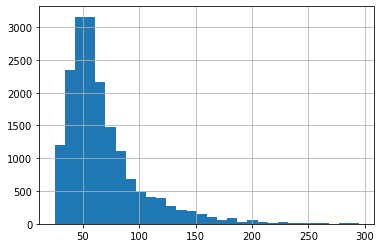

In [21]:
df.sqm.hist(bins = 30)

### Floor number of the apartment

<AxesSubplot:>

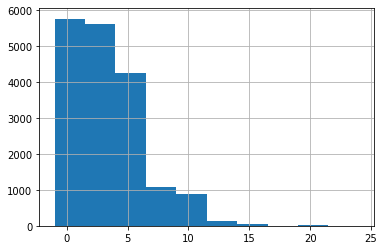

In [22]:
df.floor_no.hist()

### Sanity check

In [23]:
df[df.building_floors_num < df.floor_no].shape

(0, 15)

### Building type

In [24]:
df.building_type.value_counts()

blok                 4221
inny                 3017
block                2875
apartamentowiec      2567
apartment            1414
kamienica            1376
tenement              652
dom wielorodzinny      82
house                  37
ribbon                 22
infill                  2
loft                    1
Name: building_type, dtype: int64

### Words in text

In [25]:
df.word_parking.value_counts()

0    13131
1     4730
Name: word_parking, dtype: int64

In [26]:
df.word_balcony.value_counts()

1    11449
0     6412
Name: word_balcony, dtype: int64

In [27]:
df.word_basement.value_counts()

1    9162
0    8699
Name: word_basement, dtype: int64

In [28]:
df.word_elevator.value_counts()

0    11563
1     6298
Name: word_elevator, dtype: int64

### Price - our target variable

In [89]:
df.price

0        910000.000
1        436000.000
2        490000.000
3        831000.000
4        843000.000
            ...    
17898    635000.000
17899    528000.000
17900    718000.000
17901   1156140.000
17902    893000.000
Name: price, Length: 17861, dtype: float64

<AxesSubplot:>

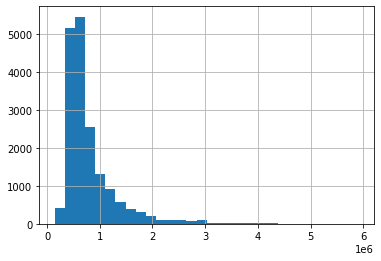

In [87]:
df.price.hist(bins=30)

<AxesSubplot:>

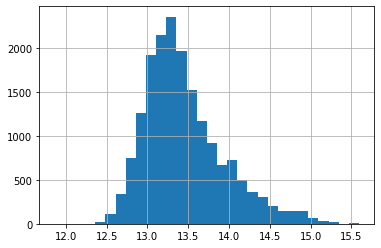

In [31]:
np.log(df.price).hist(bins=30)

Further reading: https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html

In [32]:
df['log_price'] = np.log(df.price)

<AxesSubplot:xlabel='long', ylabel='lat'>

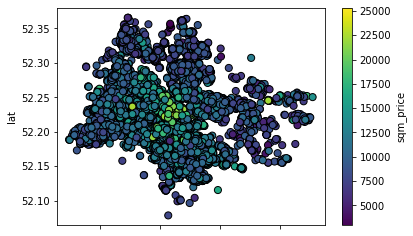

In [33]:
df.plot.scatter(x='long', y='lat', c='sqm_price',cmap='viridis', edgecolors='k', s=50)

## Variable subsets

In [34]:
df.columns

Index(['sqm_price', 'building_floors_num', 'rooms_num', 'lat', 'long',
       'build_year', 'price', 'sqm', 'floor_no', 'word_parking',
       'word_balcony', 'word_basement', 'building_type', 'word_elevator',
       'building_age', 'log_price'],
      dtype='object')

In [35]:
# Raw features
X_small = ['sqm','building_age']
X_medium = X_small + ['building_floors_num', 'rooms_num','floor_no']
X_large = X_medium + ['word_parking','word_balcony', 'word_basement', 'word_elevator']

# Include advanced, custom made features

X_adv_small = X_small + ['distance_from_center','fwd_azimuth_center']
X_adv_medium = X_medium + ['distance_from_center','fwd_azimuth_center']
X_adv_large = X_large + ['distance_from_center','fwd_azimuth_center']

# Our target variable

variable_subset = X_adv_large
target = 'price'
# target = 'log_price'

# Models

## Linear Regression

###  Testing the assumptions of Linear Regression on this dataset

In [36]:
variable_subset = ['building_floors_num', 'rooms_num','floor_no','building_age']
X_train, X_test_first, y_train, y_test_first = train_test_split(df[variable_subset], df[target], test_size=0.2, random_state=42)
linreg_first = LinearRegression(fit_intercept = True).fit(X_train,y_train)

In [37]:
test_normality(linreg_first, X_test_first, variable_subset, y_test_first)

Residuals are not normally distributed (reject H0)


#### Predictions vs True values

0.5806146383780778


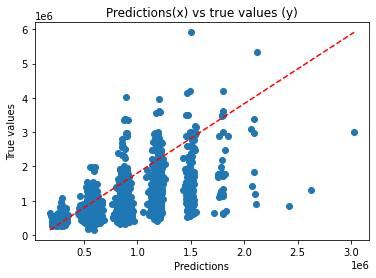

In [38]:
pred_vs_true(linreg_first,X_test_first,y_test_first)

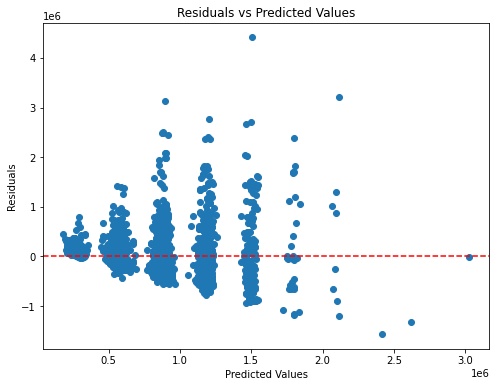

In [39]:
homoscedasticity(linreg_first, X_test_first, variable_subset, y_test_first)

In [40]:
r2_first = linreg_first.score(X_test_first,y_test_first)
r2_first

0.3363989632367509

This means we can explain only about 34% of the variance with our model with these variables: 

['building_floors_num', 'rooms_num','floor_no','building_age']

Let's add square meters.

In [41]:
variable_subset = ['sqm','building_floors_num', 'rooms_num','floor_no','building_age']
X_train, X_test_2nd, y_train, y_test_2nd = train_test_split(df[variable_subset], df[target], test_size=0.2, random_state=42)
linreg_2nd = LinearRegression(fit_intercept = True).fit(X_train,y_train)

0.8498887447777173


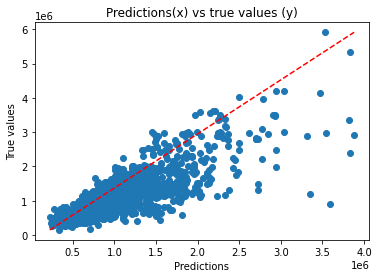

In [42]:
pred_vs_true(linreg_2nd,X_test_2nd,y_test_2nd)

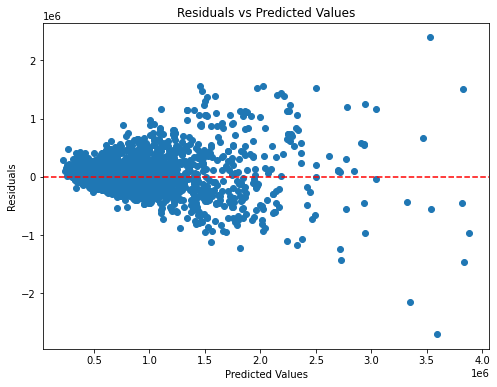

In [43]:
homoscedasticity(linreg_2nd, X_test_2nd, variable_subset, y_test_2nd)

In [93]:
r2 = linreg_2nd.score(X_test_2nd, y_test_2nd)
r2

0.7220025132669458

Variance explained increased two-fold

In [45]:
variable_subset = X_large
df_under_100k = df#[df.price < 600000]
X_train, X_test_3rd, y_train, y_test_3rd = train_test_split(df_under_100k[variable_subset], df_under_100k[target], test_size=0.2, random_state=42)
linreg_3rd = LinearRegression(fit_intercept = True).fit(X_train,y_train)

0.8508237497780875


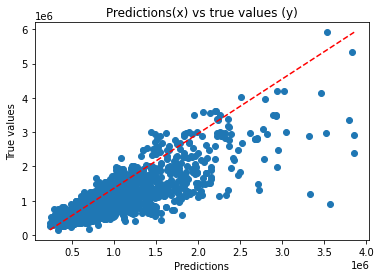

In [46]:
pred_vs_true(linreg_3rd,X_test_3rd,y_test_3rd)

In [94]:
r2 = linreg_3rd.score(X_test_3rd, y_test_3rd)
r2

0.7235672896900046

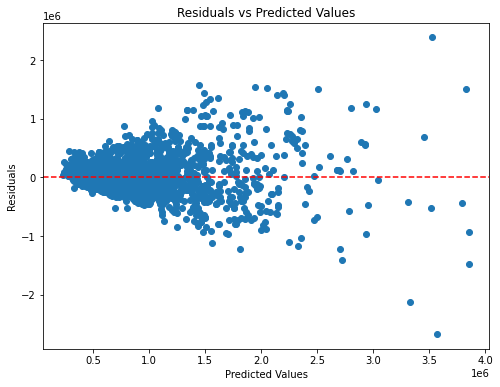

In [47]:
homoscedasticity(linreg_3rd, X_test_3rd, variable_subset, y_test_3rd)

Conclusion: Heteroscedasticity. The variance in predicted and the residuals increases for apartments that are more expensive.

Time for a poll! 

#### Correlation matrix

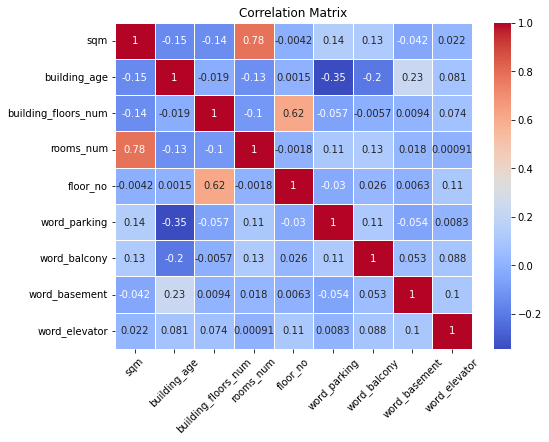

In [48]:
corr_matrix(df[X_large])

In [49]:
custom_vars = ['sqm',
 'building_age',
 'building_floors_num',
 #'rooms_num',
 'floor_no',
 'word_parking',
 'word_balcony',
 'word_basement',
 'word_elevator']

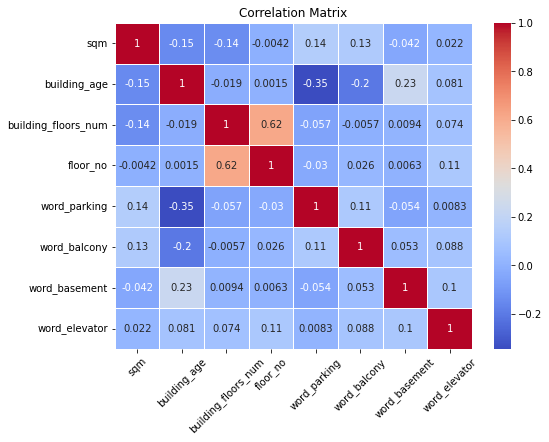

In [50]:
corr_matrix(df[custom_vars])

#### New model

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df[custom_vars], df[target], test_size=0.2, random_state=42)
linreg = LinearRegression(fit_intercept = True).fit(X_train,y_train)

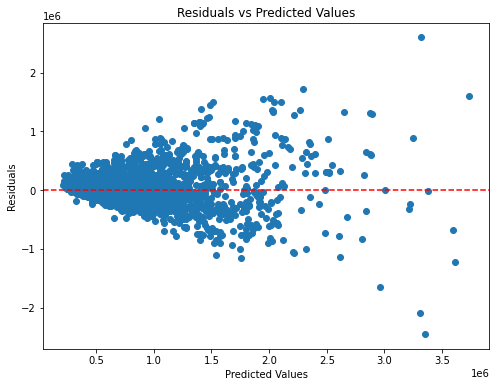

In [52]:
homoscedasticity(linreg, X_test, custom_vars, y_test)

0.8429251035477314


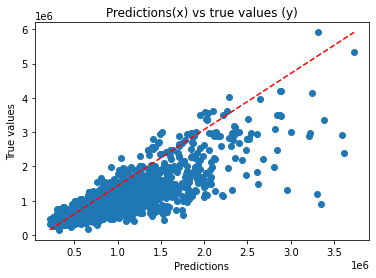

In [53]:
pred_vs_true(linreg,X_test,y_test)

0.5806146383780778


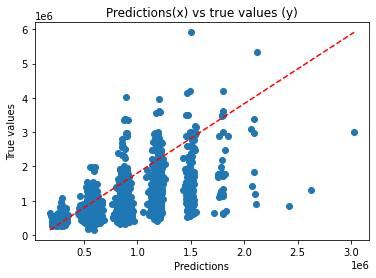

In [54]:
pred_vs_true(linreg_first,X_test_first,y_test_first)

How much of the variance can we explain? R^2

In [55]:
r2 = linreg.score(X_test, y_test)
r2

0.7103479779129066

This new model explains about 72% of the variance vs, 33% of the first one.

### statsmodels - library quick showcase

In [96]:
import statsmodels.api as sm
x = df[['sqm','building_floors_num', 'rooms_num','floor_no','building_age',"word_elevator"]]
y = df[target]

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     7747.
Date:                Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                        19:38:41   Log-Likelihood:            -2.4910e+05
No. Observations:               17861   AIC:                         4.982e+05
Df Residuals:                   17854   BIC:                         4.983e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.797e+04   8

- "const" is our $\beta_0$/intercept, constant term to the line equation
- "coef" are the coefficients, those are the $\beta_1$, $\beta_2$, ... $\beta_n$
- "std err" is the standard error of the estimates of the coefficients
- P>|t| is the "p-value". Variables having this value below 0.05 are considered to be insignificant to the model. 
- The confidence interval of our coefficient, a likelihood of 95% that our estimate falls in that range. 
- Adjusted R-squared considers only variables that significant to the model.

## Feature Engineering

In [57]:
center = (df.lat.mean(),df.long.mean())
center

(52.22617569565227, 21.008333975439342)

Text(0.5, 1.0, 'Listings with marked center')

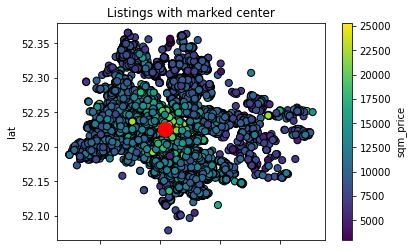

In [58]:
ax = df.plot.scatter(x='long', y='lat', c='sqm_price',cmap='viridis', edgecolors='k', s=50)

# Add a custom marker/point
custom_x = center[0]
custom_y = center[1]
custom_color = 'red'
ax.scatter(custom_y,custom_x, color=custom_color, marker='o', s=200, label='Center')

ax.set_title('Listings with marked center')

### Distance from center

In [59]:
df['distance_from_center'] = df.apply(lambda x: mpu.haversine_distance( (x.lat,x.long),(center)),axis=1)

For the curious reader on how to compute distance between two pairs of lat/long: https://en.wikipedia.org/wiki/Haversine_formula

### Forward Azimuth - the direction

In [60]:
df['fwd_azimuth_center'] = df.apply(lambda x: 180 + geodesic.inv(x.lat, x.long, center[0], center[1])[0],axis=1)

With these two new variables added we can easily describe any location now on our map by the pair of distance and angle, giving us an idea in which sector of the city a given apartment is located in!

In [61]:
final_variables = custom_vars + ['distance_from_center','fwd_azimuth_center']

X_train, X_test, y_train, y_test = train_test_split(df[final_variables], df[target], test_size=0.2, random_state=42)
linreg = LinearRegression(fit_intercept = True).fit(X_train,y_train)

r2 = linreg.score(X_test, y_test)
r2

0.7672011312588195

In [97]:
import statsmodels.api as sm
x = df[final_variables]
y = df[target]

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     5844.
Date:                Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                        19:39:31   Log-Likelihood:            -2.4757e+05
No. Observations:               17861   AIC:                         4.952e+05
Df Residuals:                   17850   BIC:                         4.953e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.782e+05 

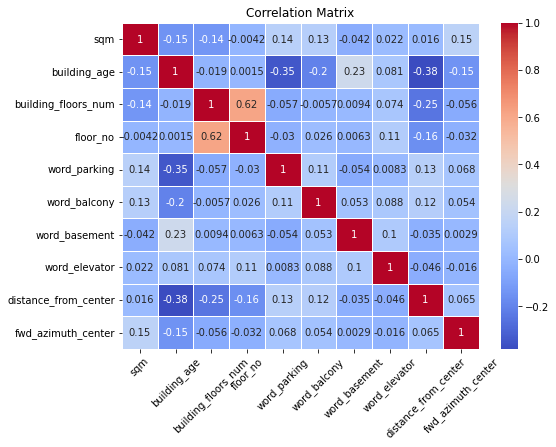

In [98]:
corr_matrix(df[final_variables])

Creating new and relevant variables added 5% to the variance explained.

# Class

In [62]:
from sklearn import metrics


class ModelWrapper():
    def __init__(self,model,name):
        self.model = model
        self.name = name

    def train(self,X,y):
        self.model = self.model.fit(X,y)
        self.variables = X.columns
    
    def score_eval(self,X_test,y_test):
        preds = self.model.predict(X_test)

        self.r2 = metrics.r2_score(y_test, preds)
        self.rms = np.sqrt(metrics.mean_squared_error(y_test, preds))
        self.mae = metrics.mean_absolute_error(y_test,preds)
        self.mape = calculate_mape(y_test, preds)

## Metrics

### R^2 (R-squared)

<img src="imgs/metric_r2.png" style="width: 200px;">

In [63]:
# Pseudo-code
# mean_y_true = np.mean(y_true)
# tss = np.sum((y_true - mean_y_true)**2)
# rss = np.sum((y_true - y_pred)**2)

Measures how well can the model explain the variance in the data = how well it describes it/predicts. 

- 0 indicates that the model has 0 power of explanation
- 1 indicates the model can explain the entire variability

### RMS (Root mean square error)

<img src="imgs/metric_rmse.jpg" style="width: 300px;">

Standard deviation of the residuals. Measures the average difference in the predicted value and the actual(true) value.

### MAE - Mean Average Error

<img src="imgs/metric_mae.png" style="width: 300px;">

Average error of the predictions.

### MAPE - Mean Absolute Percentage Error

<img src="imgs/metric_mape.webp" style="width: 250px;">

The error between actual and predicted expressed in percentages. 

# Modeling - adding models to a model container

- 'fit_intercept' : Whether to calculate the intercept for this model. If set to False, no intercept will be used in calculations (i.e. data is expected to be centered).

Instead of: 

$\hat{y}$ = $\beta_0$ + $\beta_1$ * $width$

Gives:

$\hat{y}$ = $\beta_2$ * $width$



In [64]:
models = [ModelWrapper(model = LinearRegression(fit_intercept = True), name = 'With Intercept'),
          ModelWrapper(model = LinearRegression(fit_intercept = False), name = 'No Intercept')
]

Further reading: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

## Concept of under- and overfitting

![alt text](./imgs/overfitting.png "Warsaw")


## Decision Tree Regressor

- 'criterion': The function to measure the quality of a split. 

- 'max_depth': The maximum depth of the tree. If set to None, nodes are expanded until they contain less than min_samples_split samples.

- 'min_samples_split': The minimum number of samples required to split an internal node. Can be provided as int or float - absolute number or fraction of total.

- 'min_samples_leaf': The minimum number of samples required to be at a leaf node. Can be provided as int or float - absolute number or fraction of total.

- 'max_features': The number of features to consider when looking for the best split. 

Further reading: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html


In [65]:
models += [ModelWrapper(model = DecisionTreeRegressor(criterion = 'friedman_mse'), name = 'c_friedman_mse'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 3, min_samples_split = 2), name = 'max_dp_3'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 5, min_samples_split = 2), name = 'max_dp_3'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 5, min_samples_split = 20), name = 'max_dp_5_min_split_20'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 3, min_samples_split = 20), name = 'max_dp_3_min_split_20'),
          ModelWrapper(model = DecisionTreeRegressor(),name='Default DT'), 
          ]

## Random Forest Regressor

- 'n_estimators': The number of trees in the forest (typically set to a higher value for better performance).
- 'max_depth': The maximum depth of each decision tree in the forest. If set to None, the trees will be expanded until they contain min_samples_split samples.
- 'min_samples_split': The minimum number of samples required to split an internal node.
- 'min_samples_leaf': The minimum number of samples required to be at a leaf node.
- 'max_features': The number of features to consider when looking for the best split in each tree.

Further reading: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [66]:
models += [ModelWrapper(model = RandomForestRegressor(n_estimators=2), name = 'rf_2'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=5), name = 'rf_5'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=10), name = 'rf_10'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=20), name = 'rf_20'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=50), name = 'rf_50'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=100), name = 'rf_100'),
          ]


## Training

In [67]:
X_train, X_test, y_train, y_test = train_test_split(df[final_variables], df[target], test_size=0.2, random_state=42)

In [68]:
for m in models:
    m.train(X_train,y_train)
    m.score_eval(X_test,y_test)

In [69]:
r2_list = []
rms_list = []
mae_list = []
mape_list = []
model_list = []
name_list = []

for m in models:
    model_list.append(str(m.model).split("(")[0])
    name_list.append(m.name)
    r2_list.append(m.r2)
    rms_list.append(m.rms)
    mae_list.append(m.mae)
    mape_list.append(m.mape)
    
results = pd.DataFrame({
    'model':model_list,
    'name':name_list,
    'r2': r2_list,
    'rms': rms_list,
    'mae': mae_list,
    'mape': mape_list
})

In [70]:
results

,model,name,r2,rms,mae,mape
0,LinearRegression,With Intercept,0.767,248649.493,157057.493,19.881
1,LinearRegression,No Intercept,0.763,251098.809,159278.745,20.113
2,DecisionTreeRegressor,c_friedman_mse,0.790,236169.318,106943.781,12.278
3,DecisionTreeRegressor,max_dp_3,0.724,270750.068,171924.228,21.722
4,DecisionTreeRegressor,max_dp_3,0.790,236412.451,146594.692,18.085
5,DecisionTreeRegressor,max_dp_5_min_split_20,0.790,236412.451,146594.692,18.085
6,DecisionTreeRegressor,max_dp_3_min_split_20,0.724,270750.068,171924.228,21.722
7,DecisionTreeRegressor,Default DT,0.802,229330.878,106872.781,12.348
8,RandomForestRegressor,rf_2,0.841,205368.983,106312.857,12.365
9,RandomForestRegressor,rf_5,0.884,175265.565,92706.307,10.975


## 5-fold Cross Validation

![alt text](./imgs/cv.png "Warsaw")


In [71]:
from sklearn import metrics


class ModelWrapper():
    def __init__(self,model,name):
        self.model = model
        self.name = name
        self.model_type = str(model).split("(")[0]
        
        self.r2 = []
        self.rms = []
        self.mae = []
        self.mape = []

    def train(self,X,y):
        self.model = self.model.fit(X,y)
        self.variables = X.columns
    
    def score_eval(self,X_test,y_test):
        preds = self.model.predict(X_test)

        self.r2.append(metrics.r2_score(y_test, preds))
        self.rms.append(np.sqrt(metrics.mean_squared_error(y_test, preds)))
        self.mae.append(metrics.mean_absolute_error(y_test,preds))
        self.mape.append(calculate_mape(y_test, preds))
        
    def aggregate_results(self):
        self.mean_r2 = sum(self.r2)/len(self.r2)
        self.mean_rms = sum(self.rms)/len(self.rms)
        self.mean_mae = sum(self.mae)/len(self.mae)
        self.mean_mape = sum(self.mape)/len(self.mape)

In [72]:

models = [ModelWrapper(model = LinearRegression(fit_intercept = True), name = 'With Intercept'),
          ModelWrapper(model = LinearRegression(fit_intercept = False), name = 'No Intercept')
]

models += [ModelWrapper(model = DecisionTreeRegressor(criterion = 'friedman_mse'), name = 'c_friedman_mse'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 3, min_samples_split = 2), name = 'max_dp_3'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 5, min_samples_split = 2), name = 'max_dp_3'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 5, min_samples_split = 20), name = 'max_dp_5_min_split_20'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 4, min_samples_split = 10), name = 'max_dp_4_min_split_10'),
          ModelWrapper(model = DecisionTreeRegressor(),name='Default DT'), 
          ]

models += [ModelWrapper(model = RandomForestRegressor(n_estimators=2), name = 'rf_2'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=5), name = 'rf_5'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=10), name = 'rf_10'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=20), name = 'rf_20'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=50), name = 'rf_50'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=100), name = 'rf_100'),
          ]

In [73]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=13)
# Split the data
for train_index, test_index in kf.split(df):
        X_train, X_test = df[final_variables].iloc[train_index], df[final_variables].iloc[test_index]
        y_train, y_test = df[target].iloc[train_index], df[target].iloc[test_index]
        
        # Train and evaluate the model(s)
        for m in models:
            m.train(X_train,y_train)
            m.score_eval(X_test,y_test)

In [74]:
# Aggregate results and display
data_rows = []

for m in models:
    
    m.aggregate_results()
    
    row_data = {
        'model':m.model_type,
        'name':m.name,
        'r2':m.mean_r2,
        'rms':m.mean_rms,
        'mae':m.mean_mae,
        'mape':m.mean_mape
    }
    
    data_rows.append(row_data)
agg_results = pd.DataFrame(data_rows)

In [75]:
agg_results

,model,name,r2,rms,mae,mape
0,LinearRegression,With Intercept,0.765,253450.274,159924.746,19.857
1,LinearRegression,No Intercept,0.760,255663.524,162140.841,20.095
2,DecisionTreeRegressor,c_friedman_mse,0.804,231072.142,107657.269,12.435
3,DecisionTreeRegressor,max_dp_3,0.723,275101.785,174763.146,21.640
4,DecisionTreeRegressor,max_dp_3,0.783,243311.147,148624.597,17.918
5,DecisionTreeRegressor,max_dp_5_min_split_20,0.784,242453.534,148368.589,17.899
6,DecisionTreeRegressor,max_dp_4_min_split_10,0.758,256804.095,161205.518,19.771
7,DecisionTreeRegressor,Default DT,0.805,230607.876,107159.040,12.402
8,RandomForestRegressor,rf_2,0.825,218861.905,109326.838,12.452
9,RandomForestRegressor,rf_5,0.872,186816.333,95810.959,10.940


Time for a poll question !

In [76]:
df.head()

,sqm_price,building_floors_num,rooms_num,lat,long,build_year,price,sqm,floor_no,word_parking,word_balcony,word_basement,building_type,word_elevator,building_age,log_price,distance_from_center,fwd_azimuth_center
0,13343.109,6,3,52.259,20.979,2014,910000.000,68.200,5,1,1,1,block,0,9,13.721,4.168,133.446
1,8499.025,10,2,52.223,20.900,1982,436000.000,51.300,0,0,0,0,block,0,41,12.985,7.380,181.335
2,9412.217,4,2,52.309,20.982,2009,490000.000,52.060,4,1,1,0,block,0,14,13.102,9.353,108.445
3,15679.245,6,2,52.262,20.968,2013,831000.000,53.000,2,1,0,0,block,0,10,13.630,4.818,140.000
4,11708.333,7,3,52.198,21.045,2007,843000.000,72.000,5,1,1,1,apartment,1,16,13.645,4.027,323.951


In [77]:
# Discussing evaluation metrics
# The right choice of metric for our problem and results
# Diagnosing problems in our models

In [78]:
rf = models[11].model
linreg = models[0].model
dt = models[6].model
models[6].name

'max_dp_4_min_split_10'

0.9424306681640096


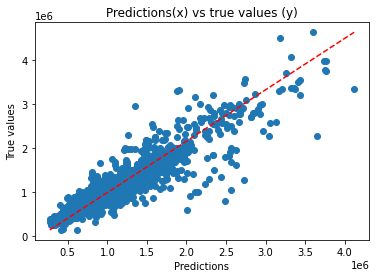

In [79]:
pred_vs_true(rf,X_test,y_test)

0.8625247991872314


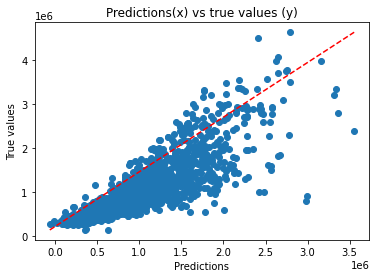

In [80]:
pred_vs_true(linreg,X_test,y_test)

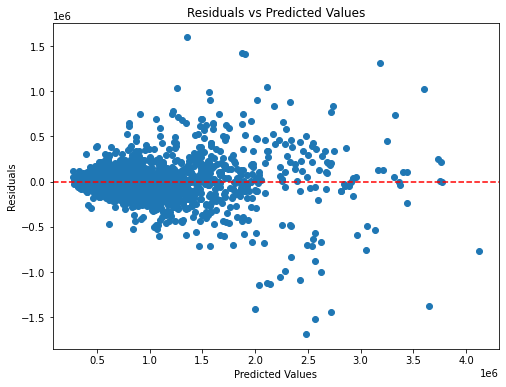

In [81]:
homoscedasticity(rf, X_test, final_variables, y_test)

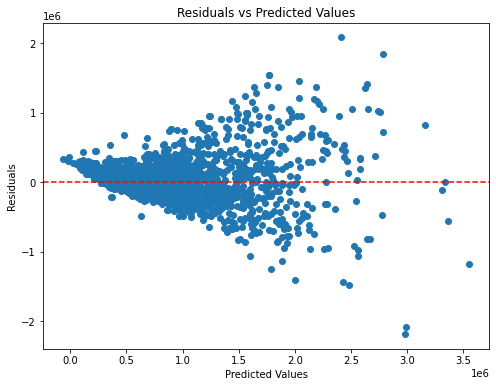

In [82]:
homoscedasticity(linreg, X_test, final_variables, y_test)

### Decision Tree - visualizing

Time for a poll! Let's look at the visualization and answer a question ! Pay attention !

In [83]:
from sklearn.tree import export_text

tree_text = export_text(dt, feature_names=final_variables)
print(tree_text)


|--- sqm <= 105.19
|   |--- sqm <= 67.22
|   |   |--- sqm <= 48.59
|   |   |   |--- sqm <= 38.61
|   |   |   |   |--- value: [428369.82]
|   |   |   |--- sqm >  38.61
|   |   |   |   |--- value: [520634.24]
|   |   |--- sqm >  48.59
|   |   |   |--- distance_from_center <= 2.97
|   |   |   |   |--- value: [821796.24]
|   |   |   |--- distance_from_center >  2.97
|   |   |   |   |--- value: [603138.69]
|   |--- sqm >  67.22
|   |   |--- distance_from_center <= 5.31
|   |   |   |--- sqm <= 87.81
|   |   |   |   |--- value: [1064693.99]
|   |   |   |--- sqm >  87.81
|   |   |   |   |--- value: [1310925.93]
|   |   |--- distance_from_center >  5.31
|   |   |   |--- sqm <= 87.29
|   |   |   |   |--- value: [763189.73]
|   |   |   |--- sqm >  87.29
|   |   |   |   |--- value: [978847.03]
|--- sqm >  105.19
|   |--- sqm <= 167.35
|   |   |--- distance_from_center <= 5.33
|   |   |   |--- sqm <= 137.40
|   |   |   |   |--- value: [1686547.73]
|   |   |   |--- sqm >  137.40
|   |   |   |   |---

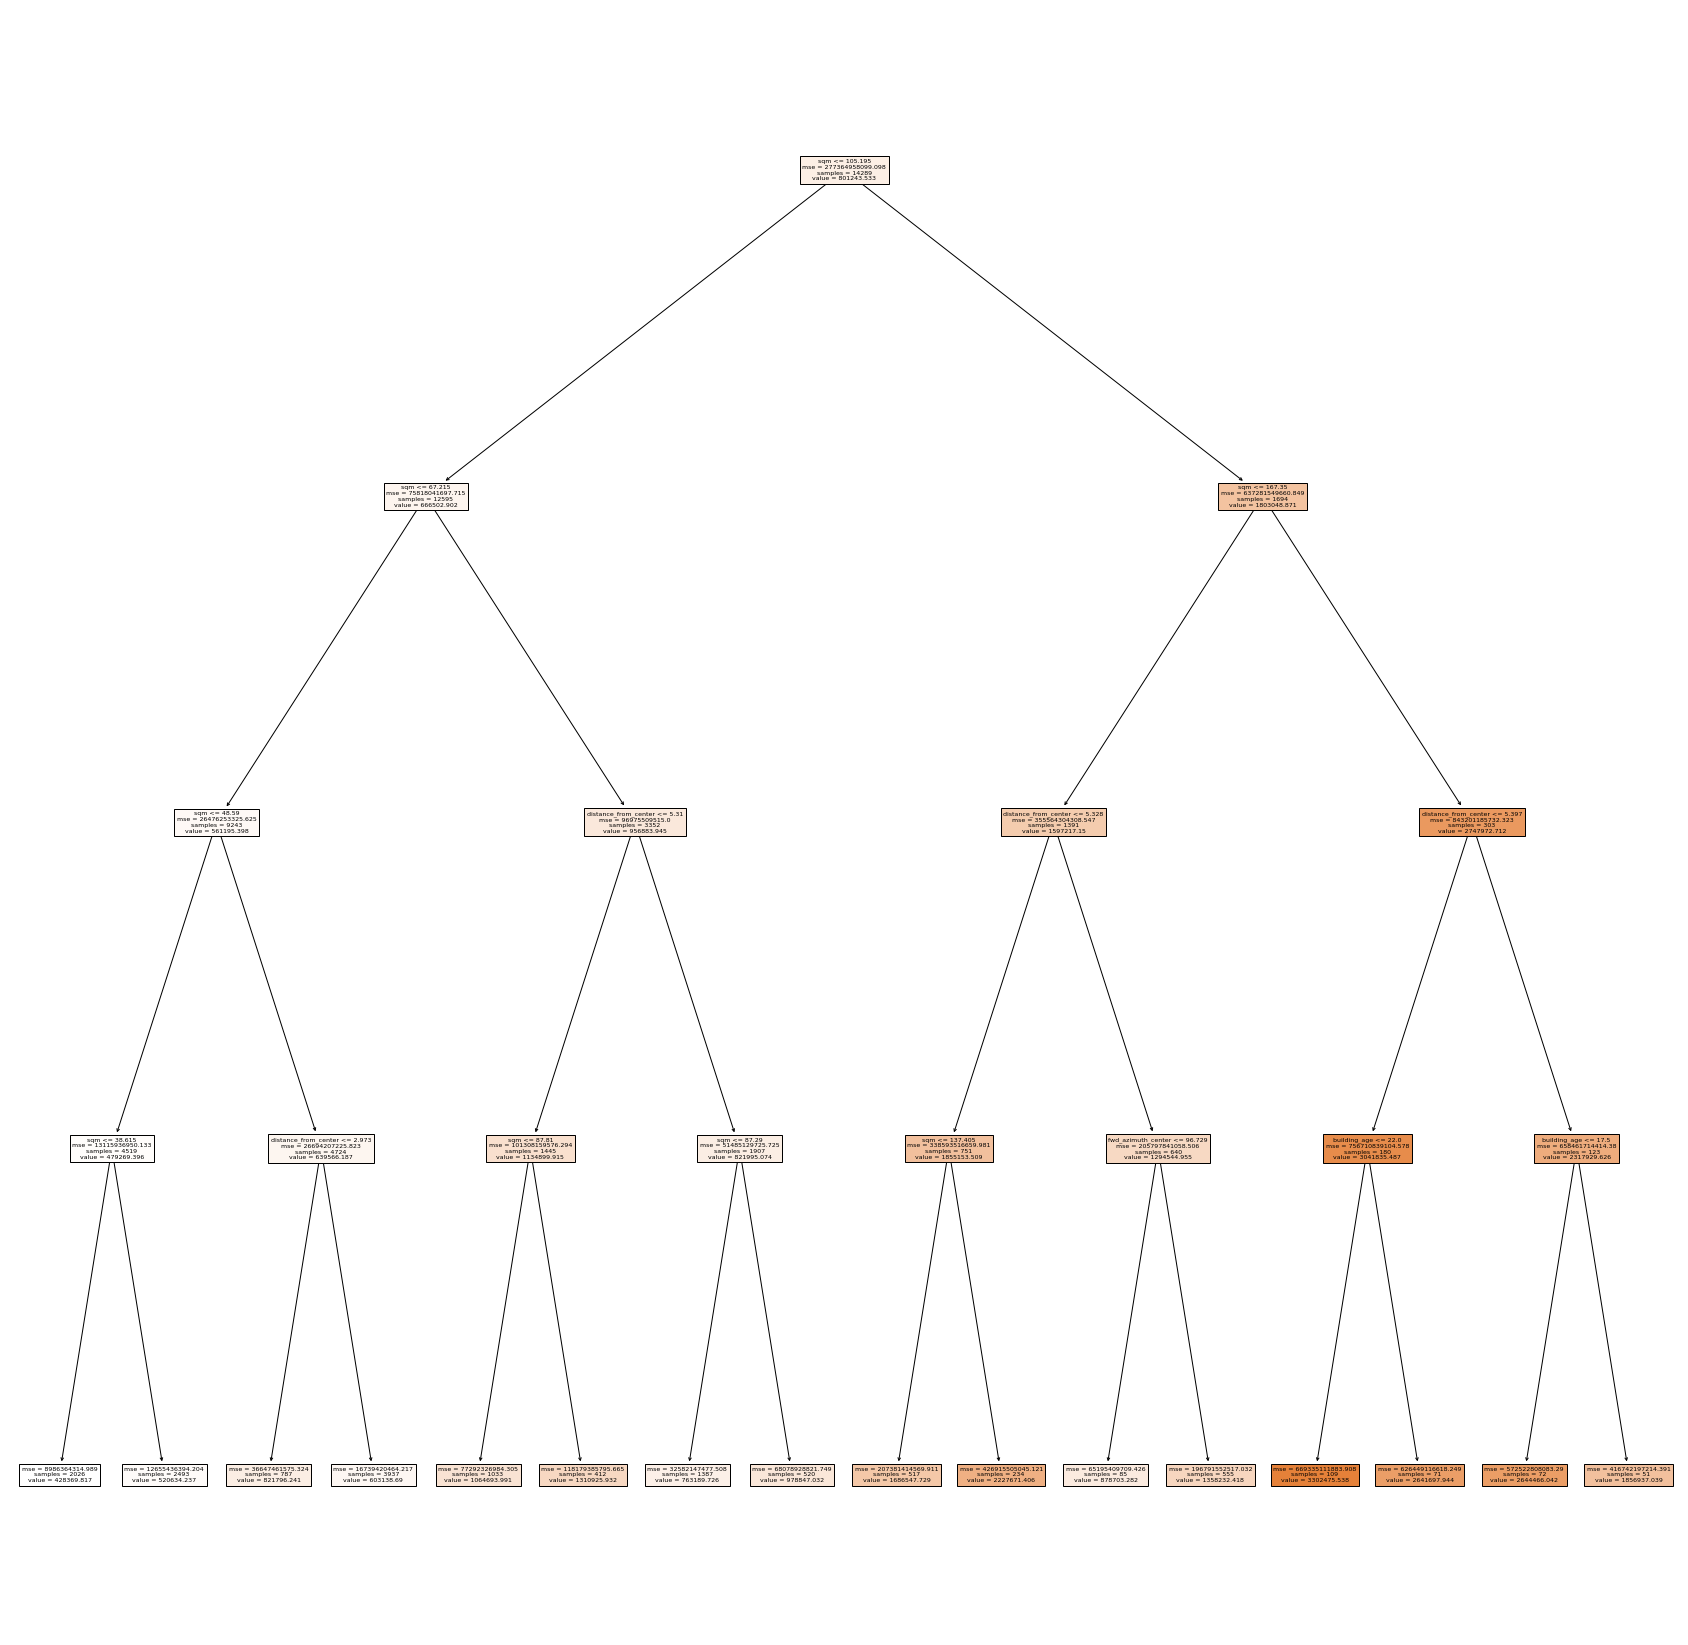

In [84]:
from sklearn import tree
plt.figure(figsize=(30,30))
tree.plot_tree(dt, feature_names=final_variables, filled=True)
plt.savefig("decision_tree.png")

# What went wrong ? 

In [85]:
df['predicted'] = np.round(dt.predict(df[final_variables]))
df['ape'] = df.apply(lambda x: round(100 * (np.abs((x[target] - x['predicted']) / x[target])),3), axis = 1)

In [86]:
df.sort_values(by='ape')[-5:]

,sqm_price,building_floors_num,rooms_num,lat,long,build_year,price,sqm,floor_no,word_parking,word_balcony,word_basement,building_type,word_elevator,building_age,log_price,distance_from_center,fwd_azimuth_center,predicted,ape
11478,3155.556,6,1,52.218,20.966,2003,142000.000,45.000,4,0,0,0,inny,0,20,11.864,3.019,189.973,520634.000,266.644
1028,4077.880,2,4,52.237,21.008,2017,596186.000,146.200,1,0,1,0,NaN,0,6,13.298,1.194,90.626,2227671.000,273.654
3534,3518.219,1,6,52.236,21.008,2019,869000.000,247.000,1,0,1,0,house,0,4,13.675,1.045,90.557,3302476.000,280.032
7732,3744.138,4,4,52.257,21.053,1937,542900.000,145.000,4,0,0,0,kamienica,0,86,13.205,4.589,33.534,2227671.000,310.328
4158,3702.759,4,4,52.257,21.053,1940,536900.000,145.000,4,0,0,0,tenement,0,83,13.194,4.538,32.736,2227671.000,314.914


- the first case is most likely misspriced
- 2nd, 3rd, 4th, 5th are probably improperly placed - someone didn't put the right adress, hence our geomapping shows it to be in a "better spot" than it really is 

Action: We have to go back all the way up again and redo all these steps. Modeling is a iterative process! =)

In [101]:
pip freeze

absl-py==0.9.0
agate==1.6.3
aiohttp==3.7.3
alembic==1.4.3
anaconda-client==1.7.2
anaconda-navigator==1.9.12
apache-airflow==1.10.12
apispec==1.3.3
APScheduler==3.6.3
argcomplete==1.12.1
asgiref==3.3.1
asn1crypto==1.5.1
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autoflake==1.4
autopep8==1.6.0
awscli==1.25.2
awsebcli==3.18.1
awsglue-local==1.0.2
awswrangler==1.6.3
azure-common==1.1.25
azure-storage-blob==2.1.0
azure-storage-common==2.1.0
Babel==2.9.0
backcall==0.2.0
backoff==1.10.0
backports.functools-lru-cache @ file:///tmp/build/80754af9/backports.functools_lru_cache_1605305165209/work
backports.tempfile==1.0
backports.weakref==1.0.post1
bcrypt==3.2.0
beautifulsoup4==4.9.0
bleach @ file:///tmp/build/80754af9/bleach_1600439572647/work
blinker==1.4
blis==0.7.4
bob-telegram-tools==1.1.0
bokeh==2.3.3
boto3==1.11.17
botocore==1.14.17
branca==0.3.1
Brotli==1.0.9
brotlipy==0.7.0
cached-property==


Keras-Preprocessing==1.1.1
kiwisolver==1.4.4
kmodes==0.12.1
korean-lunar-calendar==0.2.1
lazy-object-proxy==1.5.1
leather==0.3.4
libarchive-c==2.9
llvmlite==0.36.0
lmdb==0.98
lockfile==0.12.2
Logbook==1.5.3
lxml==4.9.0
Mako==1.1.3
Markdown==2.6.11
markdown-it-py==0.5.5
MarkupSafe @ file:///C:/ci/markupsafe_1594405949945/work
marshmallow==2.21.0
marshmallow-enum==1.5.1
marshmallow-sqlalchemy==0.24.0
mashumaro==2.9
matplotlib==3.1.3
mccabe==0.6.1
menuinst==1.4.16
mergedeep==1.3.4
minimal-snowplow-tracker==0.0.2
mistune @ file:///C:/ci/mistune_1594373272338/work
mkl-fft==1.2.0
mkl-random==1.1.1
mkl-service==2.3.0
mlflow==1.8.0
mlo-analytics===-GENERATED-IN-TAGS-BY-BUMP2VERSION-
mlo-common===-GENERATED-IN-TAGS-BY-BUMP2VERSION-
more-itertools @ file:///tmp/build/80754af9/more-itertools_1605111547926/work
mpu==0.23.0
msgpack==1.0.4
multidict==5.1.0
multipledispatch==0.6.0
multitasking==0.0.9
murmurhash==1.0.5
mutagen==1.45.1
natsort==7.0.1
navigator-updater==0.2.1
nb-conda-kernels==2.2.3
nb